## Analyse de prédiction avec et sans le score ENERGYSTAR

Dans ce notebook, nous comparons l'utilisation de la variable **ENERGYSTARScore** dans un modèle de **Gradient Boosting Regressor** pour évaluer son impact sur la précision des prédictions de consommation énergétique des bâtiments. L'objectif est d'évaluer si cette variable, qui nécessite des ressources spécifiques pour être établie, apporte une valeur ajoutée significative à notre modèle.  
  
  Nous allons examiner les performances du modèle avec et sans cette variable, afin de déterminer son utilité et son impact sur les résultats.

### Importation des bibliothèques

In [1]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from scipy.stats import uniform as sp_uniform
from scipy.stats import randint as sp_randint

# affichage de toutes les colonnes
pd.set_option('display.max_columns', None)

### Importation des données et préparation

In [2]:
# imortation des données
data = pd.read_csv('./2016_Building_Energy_FE.csv')

In [3]:
# suppression des valeurs manquantes
data = data.dropna()

In [4]:
# Définition des variables d'entrée et cibles
X = data.drop(columns=['SiteEUIWN(kBtu/sf)','GHGEmissionsIntensity', 'ENERGYSTARScore_imputer'])
y = data[['GHGEmissionsIntensity']]

# Division des données en ensembles d'entraînement et de test pour chaque variable cible
X_train_ESS, X_test_ESS, y_train_ESS, y_test_ESS = train_test_split(X, y, test_size=0.2, random_state=0)

# affichage des dimensions des données
X_train_ESS.shape, X_test_ESS.shape, y_train_ESS.shape, y_test_ESS.shape

((796, 11), (200, 11), (796, 1), (200, 1))

In [5]:
# préparation des données
# 1. Encodage OneHot pour l'ensemble d'entraînement
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
cols=data.select_dtypes(include=['object']).columns

# Encodage OneHot pour l'ensemble d'entraînement
X_train_encoded = onehot_encoder.fit_transform(X_train_ESS[cols])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=onehot_encoder.get_feature_names_out(cols), index=X_train_ESS.index)
X_train_ESS = pd.concat([X_train_ESS.drop(cols, axis=1), X_train_encoded_df], axis=1)

# Encodage OneHot pour l'ensemble de test
X_test_encoded = onehot_encoder.transform(X_test_ESS[cols])
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=onehot_encoder.get_feature_names_out(cols), index=X_test_ESS.index)
X_test_ESS = pd.concat([X_test_ESS.drop(cols, axis=1), X_test_encoded_df], axis=1)

# 3. Transformation des variables après la séparation
# Ajoutez les transformations logarithmiques ici pour X_train et X_test séparément
colslog = ['PropertyGFAParking', 'PropertyGFABuilding(s)']      
for col in colslog:
    X_train_ESS[col] = X_train_ESS[col].apply(lambda x: np.log1p(x))
    X_test_ESS[col] = X_test_ESS[col].apply(lambda x: np.log1p(x))

# 4. Normalisation de la variable ENERGYSTARScore
scaler = StandardScaler()

X_train_ESS['ENERGYSTARScore'] = scaler.fit_transform(X_train_ESS[['ENERGYSTARScore']])
X_test_ESS['ENERGYSTARScore'] = scaler.transform(X_test_ESS[['ENERGYSTARScore']])
X_train_ESS['NumberofFloors'] = scaler.fit_transform(X_train_ESS[['NumberofFloors']])
X_test_ESS['NumberofFloors'] = scaler.transform(X_test_ESS[['NumberofFloors']])
X_train_ESS['YearBuilt'] = scaler.fit_transform(X_train_ESS[['YearBuilt']])
X_test_ESS['YearBuilt'] = scaler.transform(X_test_ESS[['YearBuilt']])

# Transformation de la variable cible pour l'ensemble d'entraînement
y_train_transformed_ESS = y_train_ESS.apply(lambda x: np.log1p(x))
y_train_transformed_ESS = y_train_transformed_ESS.values.ravel()

c:\Users\fathi\anaconda3\envs\OCR\lib\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### GB pour dataset avec la variable ENERGYSTARScore

In [6]:
# Initialisation du modèle GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Entraînement du modèle avec les paramètres par défaut pour voir les performances de base
gbr.fit(X_train_ESS, y_train_transformed_ESS)

# Prédictions sur l'ensemble de test avec le modèle de base
y_pred_gbr = gbr.predict(X_test_ESS)
y_pred_gbr = np.expm1(y_pred_gbr)

# Évaluation des prédictions de base
print("Score R2 (Gradient Boosting sans optimisation) : ", r2_score(y_test_ESS, y_pred_gbr))
print("MAE (Gradient Boosting sans optimisation) : ", mean_absolute_error(y_test_ESS, y_pred_gbr))

Score R2 (Gradient Boosting sans optimisation) :  0.718189278626913
MAE (Gradient Boosting sans optimisation) :  0.49706436025997874


In [7]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)

# Hyperparamètres à tester
param_grid = {
    'n_estimators': [120,150,160],
    'max_depth': [3,4, None],
    'min_samples_split': [6,5],
    'min_samples_leaf': [1, 2],
    'learning_rate': [ 0.05, 0.08, 0.09],
    'max_features': ['sqrt', 'log2']
}

# Initialisation du GridSearchCV
grid_search_gb = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Entraînement du modèle
grid_search_gb.fit(X_train_ESS, y_train_transformed_ESS.squeeze())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres : ", grid_search_gb.best_params_)

# Évaluation du modèle optimisé
best_gb_ESS = grid_search_gb.best_estimator_
print("Score R2 pour chaque fold:", cross_val_score(best_gb_ESS, X_train_ESS, y_train_transformed_ESS.squeeze(), cv=3, scoring='r2'))

y_pred_optimized_gb_ESS = best_gb_ESS.predict(X_test_ESS)
y_pred_optimized_gb_ESS = np.expm1(y_pred_optimized_gb_ESS)
y_pred_optimized_gb_ESS = pd.Series(y_pred_optimized_gb_ESS.ravel(), index=y_test_ESS.index)

print("Score R2 (Gradient Boosting optimisé) : ", r2_score(y_test_ESS, y_pred_optimized_gb_ESS))
print("MAE (Gradient Boosting optimisé) : ", mean_absolute_error(y_test_ESS, y_pred_optimized_gb_ESS))

Meilleurs paramètres :  {'learning_rate': 0.05, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 120}
Score R2 pour chaque fold: [0.76593148 0.66596816 0.74915709]
Score R2 (Gradient Boosting optimisé) :  0.6881437146291594
MAE (Gradient Boosting optimisé) :  0.5344633039499853


### GB pour dataset sans la variable ENERGYSTARScore

In [8]:
# suppresion de la variable ENERGYSTARScore
X_test_no_ESS=X_test_ESS.drop(['ENERGYSTARScore'], axis=1)
X_train_no_ESS=X_train_ESS.drop(['ENERGYSTARScore'], axis=1)

In [9]:
# Initialisation du modèle GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)

# Entraînement du modèle avec les paramètres par défaut pour voir les performances de base
gbr.fit(X_train_no_ESS, y_train_transformed_ESS)

# Prédictions sur l'ensemble de test avec le modèle de base
y_pred_gbr = gbr.predict(X_test_no_ESS)
y_pred_gbr = np.expm1(y_pred_gbr)

# Évaluation des prédictions de base
print("Score R2 (Gradient Boosting sans optimisation) : ", r2_score(y_test_ESS, y_pred_gbr))
print("MAE (Gradient Boosting sans optimisation) : ", mean_absolute_error(y_test_ESS, y_pred_gbr))

Score R2 (Gradient Boosting sans optimisation) :  0.6893886858601251
MAE (Gradient Boosting sans optimisation) :  0.5306544115914062


In [10]:
# Gradient Boosting Regressor
gb = GradientBoostingRegressor(random_state=42)

# Hyperparamètres à tester
param_grid = {
    'n_estimators': [50,100,120],
    'max_depth': [4,5,None],
    'min_samples_split': [6,5],
    'min_samples_leaf': [2,3],
    'learning_rate': [0.09,0.08, 0.07],
    'max_features': ['sqrt','log2']
}

# Initialisation du GridSearchCV
grid_search_gb_no_ESS = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Entraînement du modèle
grid_search_gb_no_ESS.fit(X_train_no_ESS, y_train_transformed_ESS.squeeze())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres : ", grid_search_gb_no_ESS.best_params_)

# Évaluation du modèle optimisé
best_gb_no_ESS = grid_search_gb_no_ESS.best_estimator_
print("Score R2 pour chaque fold:", cross_val_score(best_gb_no_ESS, X_train_no_ESS, y_train_transformed_ESS.squeeze(), cv=3, scoring='r2'))

y_pred_optimized_gb_no_ESS = best_gb_no_ESS.predict(X_test_no_ESS)
y_pred_optimized_gb_no_ESS = np.expm1(y_pred_optimized_gb_no_ESS)
y_pred_optimized_gb_no_ESS = pd.Series(y_pred_optimized_gb_no_ESS.ravel(), index=y_test_ESS.index)

print("Score R2 (Gradient Boosting optimisé) : ", r2_score(y_test_ESS, y_pred_optimized_gb_no_ESS))
print("MAE (Gradient Boosting optimisé) : ", mean_absolute_error(y_test_ESS, y_pred_optimized_gb_no_ESS))

Meilleurs paramètres :  {'learning_rate': 0.09, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 120}
Score R2 pour chaque fold: [0.68967399 0.56939223 0.70342949]
Score R2 (Gradient Boosting optimisé) :  0.6812047626016648
MAE (Gradient Boosting optimisé) :  0.5495995443213977


### Comparaison des résultat avec et sans la variable ENERGYSTARScore

#### Valeurs réelles vs valeurs prédites

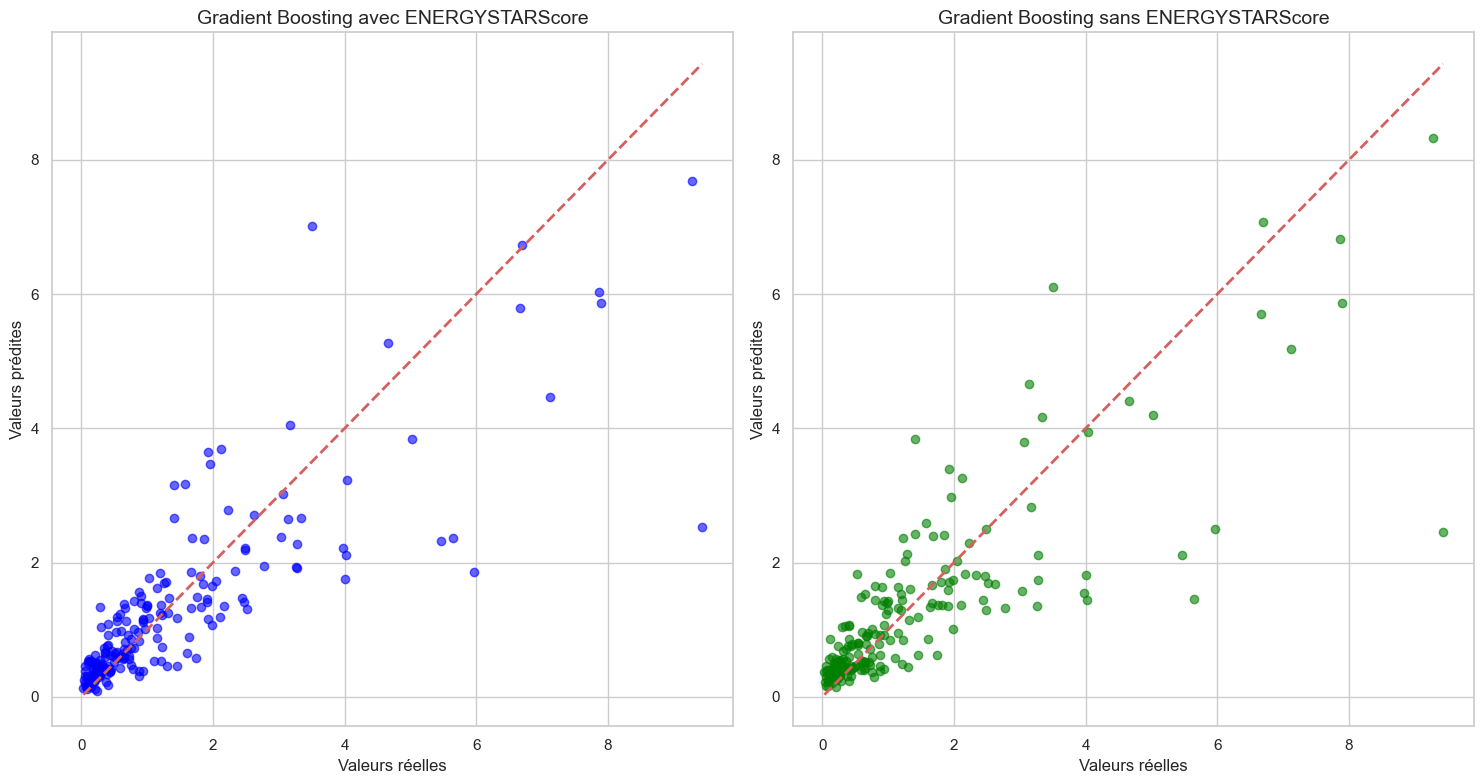

In [11]:
# Configuration du style
sns.set(style='whitegrid', palette='muted')

# Définition de la taille de la police pour les graphiques
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=11)

# Création d'une figure avec plusieurs subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 8))  # 1 ligne, 2 colonnes

# Affichage du premier subplot pour le modèle avec la variable ENERGYSTARScore
axs[0].scatter(y_test_ESS, y_pred_optimized_gb_ESS, alpha=0.6, color='blue', label='Gradient Boosting')
axs[0].plot([y_test_ESS.min(), y_test_ESS.max()], [y_test_ESS.min(), y_test_ESS.max()], '--r', linewidth=2)
axs[0].set_title('Gradient Boosting avec ENERGYSTARScore')
axs[0].set_xlabel('Valeurs réelles')
axs[0].set_ylabel('Valeurs prédites')

# Affichage du deuxième subplot pour le modèle sans la variable ENERGYSTARScore
axs[1].scatter(y_test_ESS, y_pred_optimized_gb_no_ESS, alpha=0.6, color='green', label='Gradient Boosting')
axs[1].plot([y_test_ESS.min(), y_test_ESS.max()], [y_test_ESS.min(), y_test_ESS.max()], '--r', linewidth=2)
axs[1].set_title('Gradient Boosting sans ENERGYSTARScore')
axs[1].set_xlabel('Valeurs réelles')
axs[1].set_ylabel('Valeurs prédites')

# Ajustement des marges entre les graphiques
plt.tight_layout()

# Affichage de la figure finale
plt.show()


#### Importance des variables avec SHAP

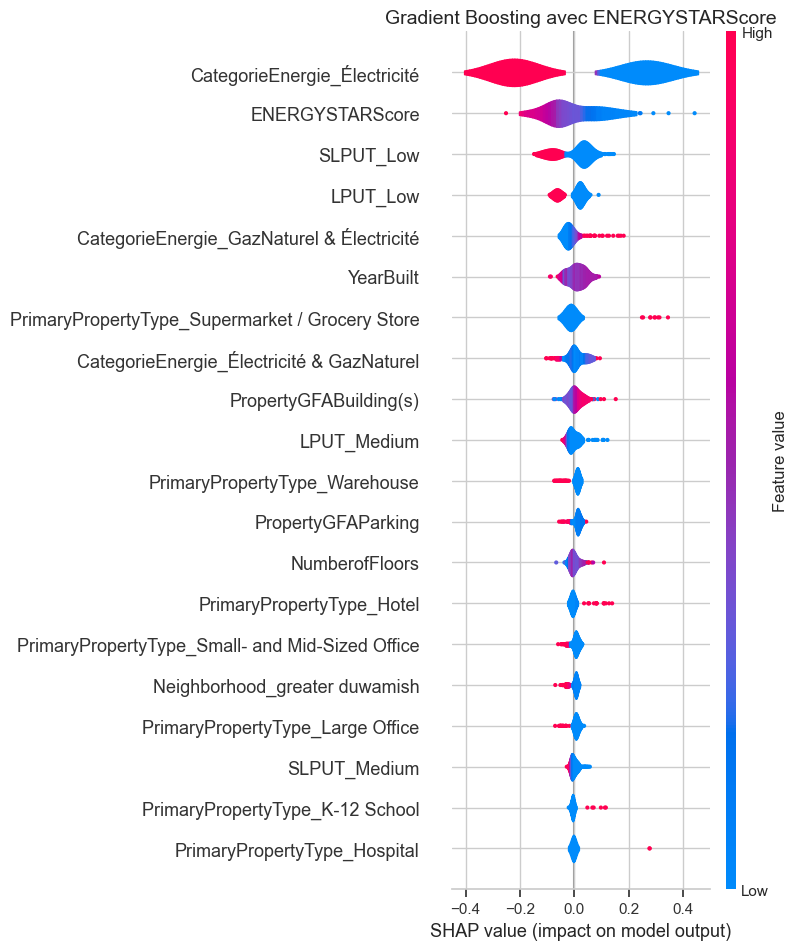

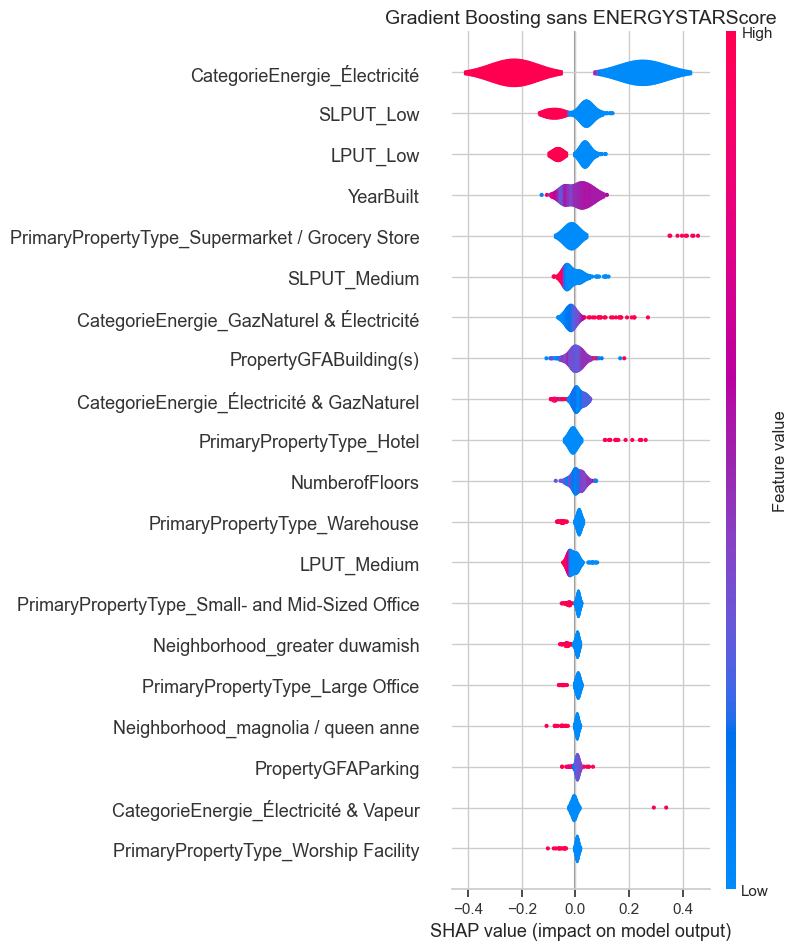

In [12]:
import shap

# Explainer pour chaque modèle
explainer_gb_ESS = shap.TreeExplainer(best_gb_ESS)
explainer_gb_no_ESS = shap.TreeExplainer(best_gb_no_ESS)

# shap values pour chaque modèle
shap_values_gb_ESS = explainer_gb_ESS.shap_values(X_test_ESS)
shap_values_gb_no_ESS = explainer_gb_no_ESS.shap_values(X_test_no_ESS)

# Création d'un objet shap.summary_plot pour chaque modèle
shap.summary_plot(shap_values_gb_ESS, X_test_ESS, plot_type="violin", show=False)
plt.title('Gradient Boosting avec ENERGYSTARScore')
plt.show()

shap.summary_plot(shap_values_gb_no_ESS, X_test_no_ESS, plot_type="violin", show=False)
plt.title('Gradient Boosting sans ENERGYSTARScore')
plt.show()